# 1D harmonic oscillator physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```



In [11]:
import sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Append custom classes to  sys.path

sys.path.append('../static/py/classes/')
from classic_models import FCN, SimpleRNN, VanillaRNN
from visualization import Visualization 


In [12]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

For this problem, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $x\in [0,1]$.

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


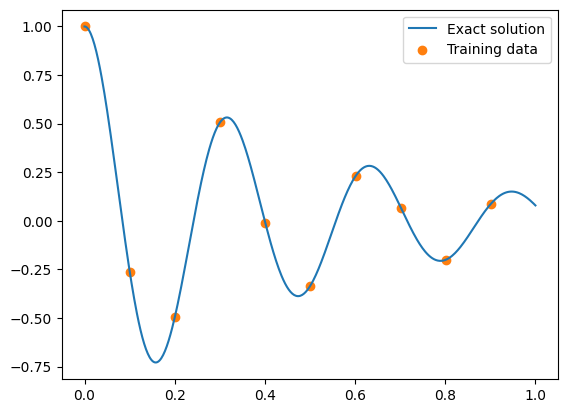

In [29]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:500:50]
y_data = y[0:500:50]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

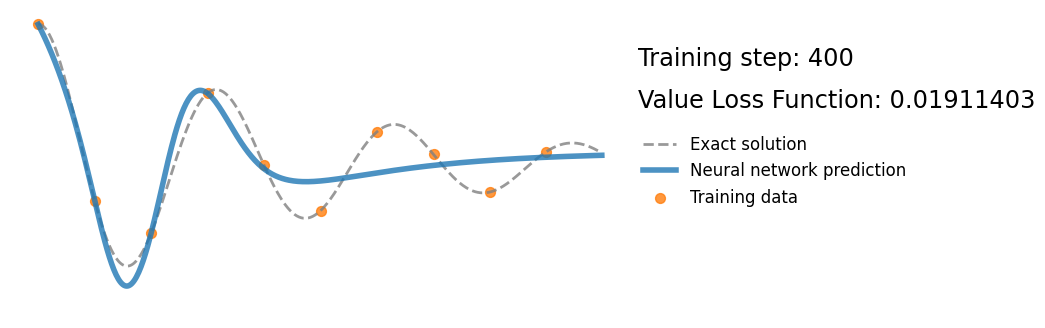

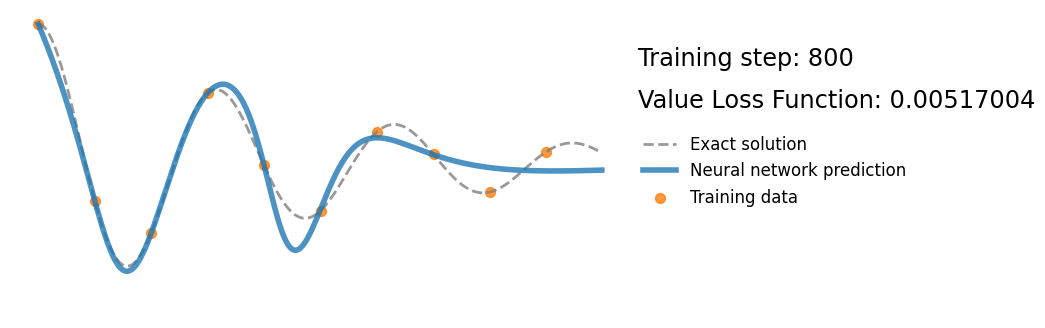

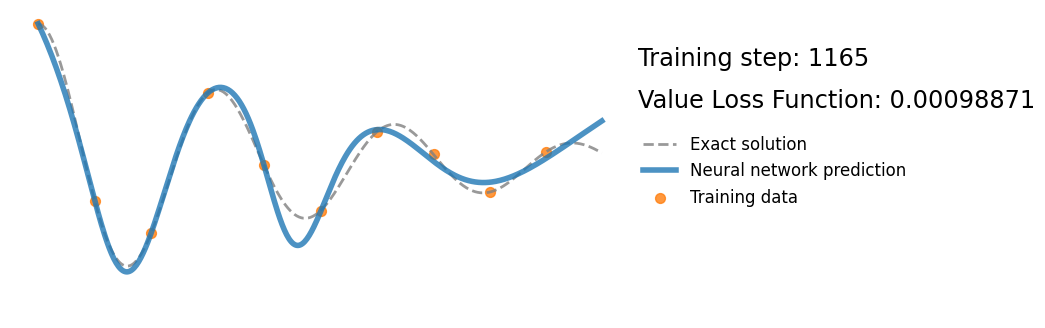

In [32]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []

epochs = 2000
interval_images = epochs/10
interval_plots = epochs/5
min_error_accepted = 0.001
for i in range(epochs):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % interval_images == 0: 
        
        yh = model(x).detach()
        
        Visualization.plot_result(i+1,loss,x,y,x_data,y_data,yh,)
        
        file = "../../media/harmonic_oscillator/plots/nn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i+1) % interval_plots == 0: 
            plt.show()
        else: plt.close("all")
    
    if (loss <= min_error_accepted) :
        yh = model(x.unsqueeze(2)).detach()
        
        yh = yh.view(-1,1)
        Visualization.plot_result(i+1,loss, x,y,x_data,y_data,yh)
        plt.show()
        break 

            
            
Visualization.save_gif("../../media/harmonic_oscillator/gifs/nn.gif", files, fps=20, loop=0)

## RNN

> Finally, we append the solution from to use Recurrent Neural Network, we will hope a better behaviour that with a Classic Neural Network

C:\Users\Bryan Rodriguez\AppData\Local\Temp\ipykernel_16416\427847891.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x_data, dtype=torch.float32)
C:\Users\Bryan Rodriguez\AppData\Local\Temp\ipykernel_16416\427847891.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.float32)


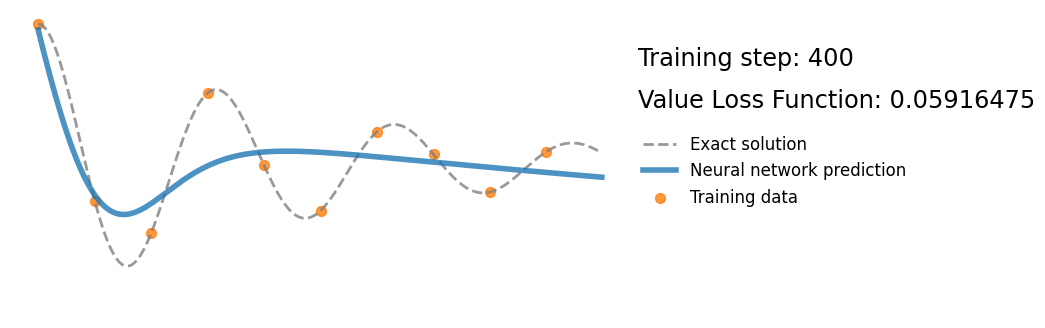

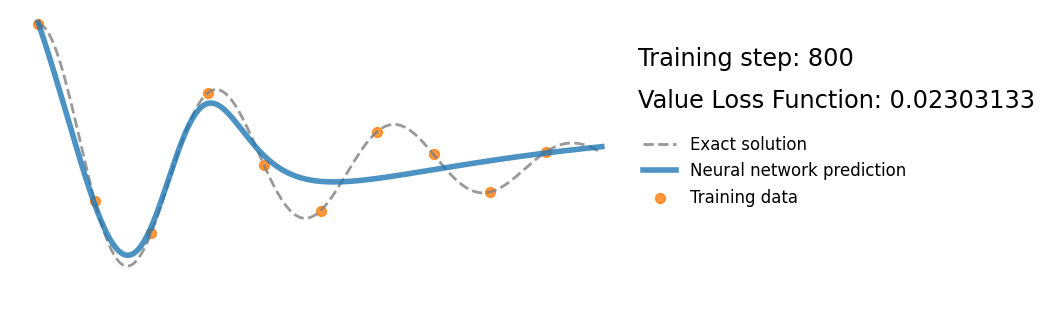

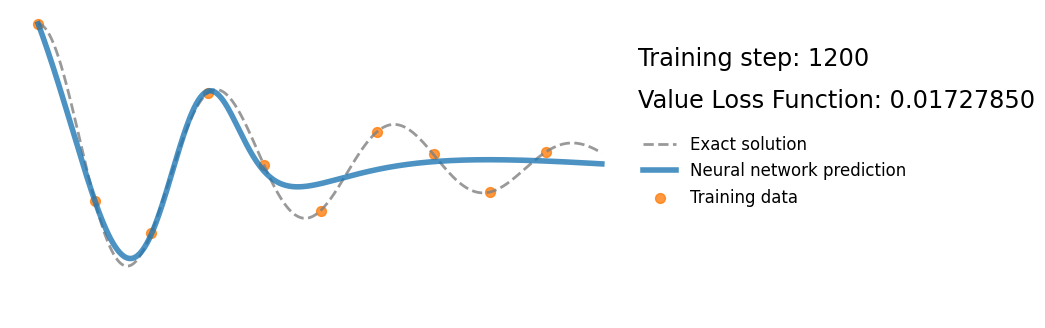

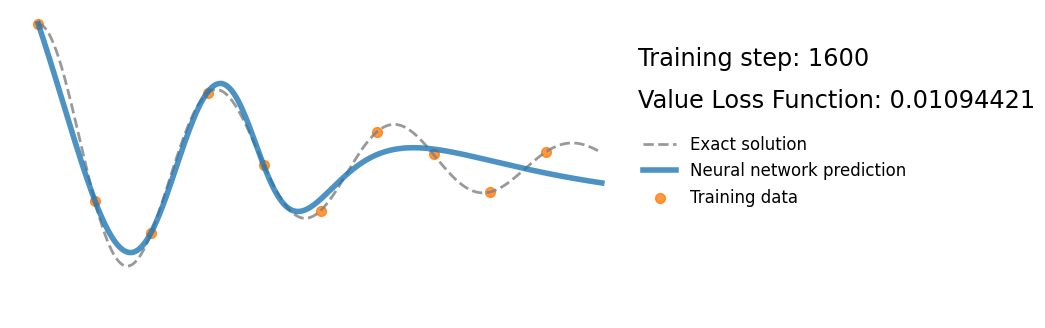

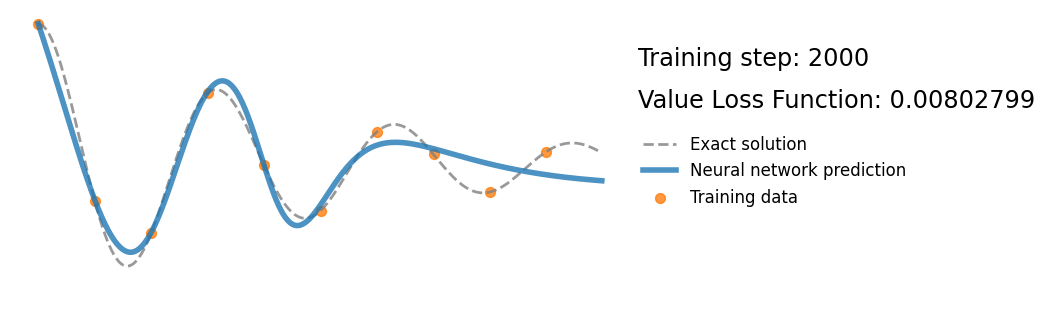

In [33]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)
torch.manual_seed(123)

input_size = 1
hidden_size = 10
# n_layers = 1
output_size = 1
model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epoch_loss = 0
optimizer.zero_grad()
min_error_accepted = 0.001
epochs = 2000
interval_images = epochs/10
interval_plots = epochs/5
min_error_accepted = 0.001
for j in range(epochs):
    model.train()
    # compute the "data loss"
    yh = model(x_data.unsqueeze(2))
    optimizer.zero_grad()
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # backpropagate joint loss
    loss = loss1# add two loss terms together
    loss1.backward()
    optimizer.step()
    
    #$print('loss1 = ',loss1,', loss2 = ',loss2,', loss = ', loss)

    # plot the result as training progresses
    if (j+1) % interval_images == 0: 
        
        yh = model(x.unsqueeze(2)).detach()
        # xp = x_physics.detach()
        yh = yh.view(-1,1)
        # print(x)
        
        Visualization.plot_result(j+1,loss, x,y,x_data,y_data,yh,)
        
        file = "../../media/harmonic_oscillator/plots/rnn_%.8i.png"%(j+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        

        if (j+1) % interval_plots == 0: 
            plt.show()
        else: plt.close("all")

    if (loss <= min_error_accepted) :
        yh = model(x.unsqueeze(2)).detach()
        xp = x_physics.detach()
        yh = yh.view(-1,1)
        Visualization.plot_result(j+1,loss, x,y,x_data,y_data,yh)
        plt.show()
        break 
            
Visualization.save_gif("../../media/harmonic_oscillator/gifs/rnn.gif", files, fps=20, loop=0)

## PIRNN

Finally, we append the solution from to use Physics Informed Recurrent Neural Network, we will hope a better behaviour that with a Classic Neural Network

C:\Users\Bryan Rodriguez\AppData\Local\Temp\ipykernel_16416\2795197423.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(x_data, dtype=torch.float32)
C:\Users\Bryan Rodriguez\AppData\Local\Temp\ipykernel_16416\2795197423.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_data = torch.tensor(y_data, dtype=torch.float32)


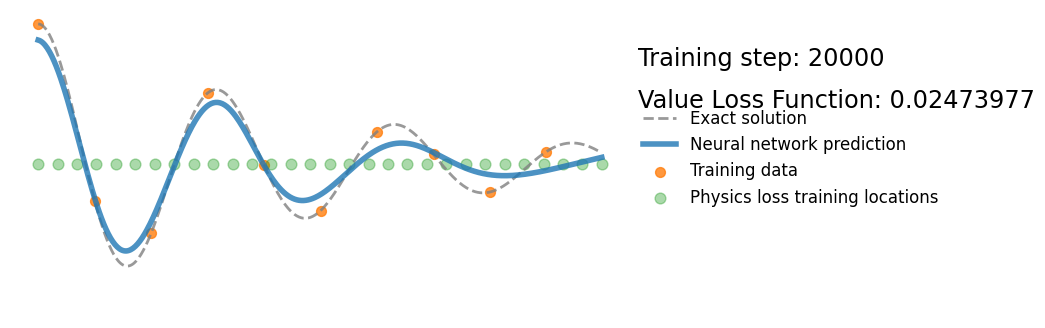

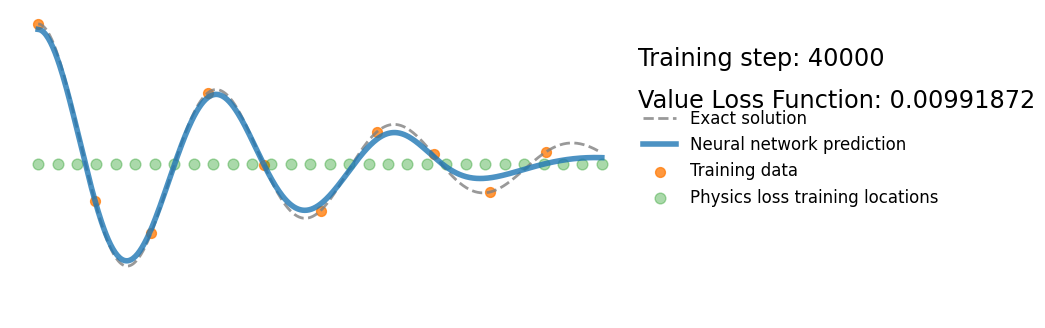

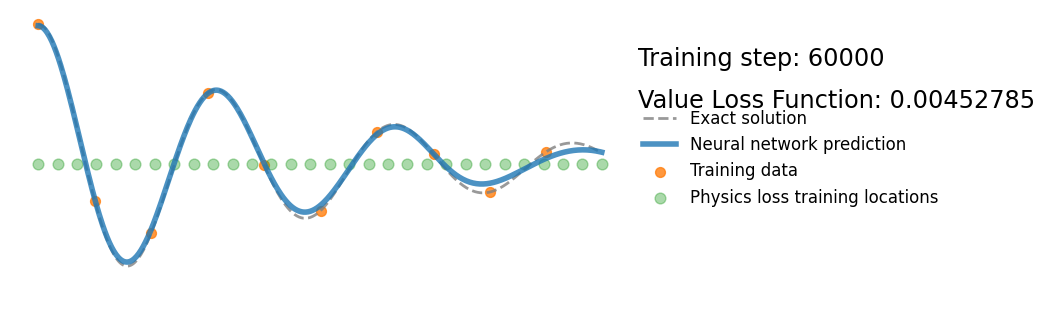

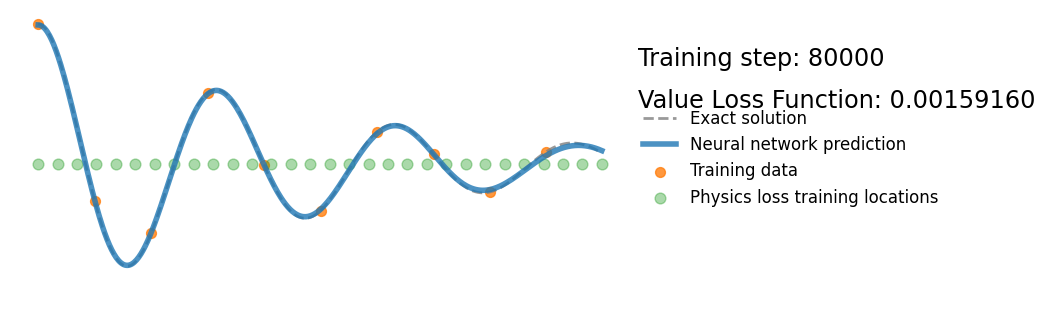

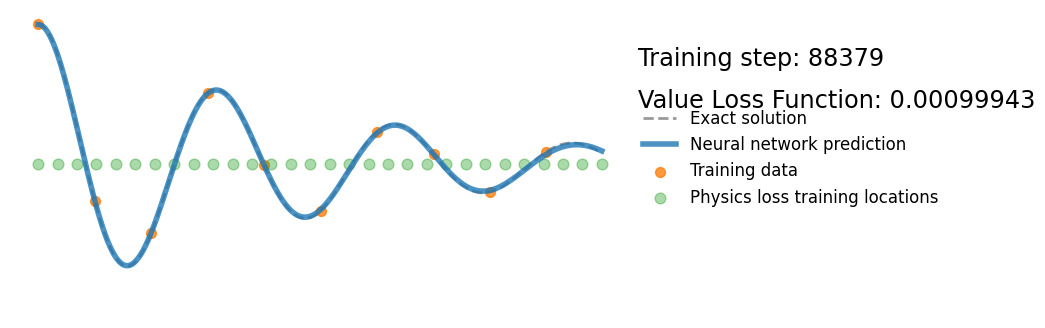

In [34]:
x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)
torch.manual_seed(123)

input_size = 1
hidden_size = 10
n_layers = 1
output_size = 1
model = VanillaRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


epoch_loss = 0
optimizer.zero_grad()
epochs = 100000
interval_images = epochs/10
interval_plots = epochs/5
min_error_accepted = 0.001

for j in range(epochs):
    model.train()
    # compute the "data loss"
    yh = model(x_data.unsqueeze(2))
    # print(x_data)
    # print(x_data.unsqueeze(2))
    optimizer.zero_grad()
    loss1 = torch.mean((yh-y_data)**2)# use mean squared error

    # compute the "physics loss"
    yhp = model(x_physics.unsqueeze(2))
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss1 + loss2 # add two loss terms together

    loss.backward()
    optimizer.step()
    #$print('loss1 = ',loss1,', loss2 = ',loss2,', loss = ', loss)

    # plot the result as training progresses
    if (j+1) % interval_images == 0: 
        
        yh = model(x.unsqueeze(2)).detach()
        xp = x_physics.detach()
        yh = yh.view(-1,1)
        
        Visualization.plot_result(j+1,loss, x,y,x_data,y_data,yh, xp)
        
        file = "../../media/harmonic_oscillator/plots/rnn_pinn_%.8i.png"%(j+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        

        if (j+1) % interval_plots == 0: 
            plt.show()
        else: plt.close("all")


    if (loss <= min_error_accepted) :
        yh = model(x.unsqueeze(2)).detach()
        xp = x_physics.detach()
        yh = yh.view(-1,1)
        Visualization.plot_result(j+1,loss, x,y,x_data,y_data,yh, xp)
        plt.show()
        break 
Visualization.save_gif("../../media/harmonic_oscillator/gifs/rnn_pinn.gif", files, fps=20, loop=0)